In [1]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

In [2]:
dataset = TUDataset(root="TUDataset", name="MUTAG")
dataset[31]

Data(edge_index=[2, 50], x=[24, 7], edge_attr=[50, 4], y=[1])

In [3]:
data = dataset[0]

In [4]:
atom_types = ["C", "N", "O", "F", "I", "Cl", "Br"]

node_labels = {i: atom_types[x.argmax().item()] for i, x in enumerate(data.x)}
print(node_labels) 

{0: 'C', 1: 'C', 2: 'C', 3: 'C', 4: 'C', 5: 'C', 6: 'C', 7: 'C', 8: 'C', 9: 'C', 10: 'C', 11: 'C', 12: 'C', 13: 'C', 14: 'N', 15: 'O', 16: 'O'}


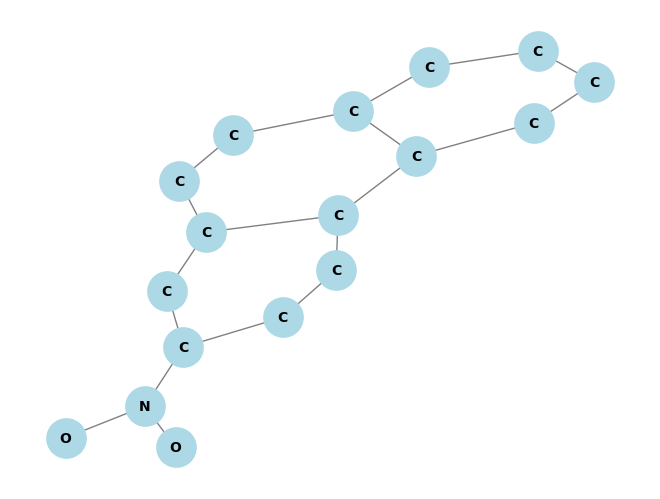

In [5]:
import networkx as nx
from torch_geometric.utils import to_networkx
from matplotlib import pyplot as plt

G = to_networkx(data, to_undirected=True)

pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True, labels=node_labels, node_color="lightblue", edge_color="gray", node_size=800, font_size=10, font_weight="bold")
plt.show()

In [6]:
import sys
import os

# Lấy đường dẫn thư mục gốc (project_root)
project_root = os.path.abspath(os.path.join(os.path.dirname('model'), ".."))
sys.path.append(project_root)

In [7]:
import torch
from torch_geometric.data import DataLoader
from model.gin import GIN, get_mean_node_embeddings_df

test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = GIN(
        in_channels=dataset.num_features,
        hidden_channels=32,
        out_channels=dataset.num_classes,
        num_layers=5,
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#     # blackbox
# df = get_mean_node_embeddings_df(model,  device, test_loader)

/Users/admin/Documents/Screenshots/LORE/.env/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
from sklearn.model_selection import train_test_split

torch.manual_seed(42)  # Đảm bảo kết quả tái lập
indices = torch.randperm(len(dataset)).tolist()
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_idx, temp_idx = train_test_split(indices, train_size=train_size, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=test_size, random_state=42)

train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
test_dataset = dataset[test_idx]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/Users/admin/Documents/Screenshots/LORE/.env/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch, data.batch_size)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch, data.batch_size)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

In [10]:
import time
times = []
for epoch in range(1, 101):
    start = time.time()
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    times.append(time.time() - start)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Test: {test_acc:.4f}')
print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')

Epoch: 001, Loss: 0.5643, Train: 0.6800, Test: 0.6500
Epoch: 002, Loss: 0.4946, Train: 0.6800, Test: 0.6500
Epoch: 003, Loss: 0.4652, Train: 0.6867, Test: 0.6500
Epoch: 004, Loss: 0.3920, Train: 0.7133, Test: 0.7000
Epoch: 005, Loss: 0.3756, Train: 0.7200, Test: 0.8000
Epoch: 006, Loss: 0.3694, Train: 0.7733, Test: 0.8500
Epoch: 007, Loss: 0.3612, Train: 0.7800, Test: 0.8500
Epoch: 008, Loss: 0.3793, Train: 0.7867, Test: 0.8500
Epoch: 009, Loss: 0.3511, Train: 0.8000, Test: 0.8500
Epoch: 010, Loss: 0.3445, Train: 0.8067, Test: 0.8500
Epoch: 011, Loss: 0.3189, Train: 0.8000, Test: 0.7500
Epoch: 012, Loss: 0.3754, Train: 0.8067, Test: 0.8500
Epoch: 013, Loss: 0.3278, Train: 0.8467, Test: 0.7500
Epoch: 014, Loss: 0.3487, Train: 0.8600, Test: 0.7500
Epoch: 015, Loss: 0.3429, Train: 0.7533, Test: 0.6000
Epoch: 016, Loss: 0.3520, Train: 0.5600, Test: 0.5000
Epoch: 017, Loss: 0.3436, Train: 0.8867, Test: 0.7500
Epoch: 018, Loss: 0.3696, Train: 0.8600, Test: 0.8000
Epoch: 019, Loss: 0.3922, Tr

In [11]:
model.eval()

# blackbox
df = get_mean_node_embeddings_df(model,  device, train_loader)
print('df: ', df)

df:            n_0       n_1       n_2       n_3       n_4       n_5       n_6  \
0    0.006312  0.009080  0.131551  0.221930  0.029954  0.008005  0.049309   
1    0.010790  0.011223  0.344613  0.016498  0.017112  0.250166  0.029354   
2    0.007539  0.007539  0.019211  0.602287  0.629883  0.022532  0.714527   
3    0.025038  0.042191  0.079523  0.042191  0.025038  0.022035  0.032142   
4    0.012508  0.012508  0.164656  0.030409  0.015398  0.030409  0.164656   
..        ...       ...       ...       ...       ...       ...       ...   
145  0.044126  0.044126  0.059057  0.095693  0.095658  0.059057  0.077236   
146  0.044924  0.005886  0.015171  0.062857  0.080046  0.093686  0.079427   
147  0.013239  0.059573  0.037917  0.035885  0.016656  0.055115  0.036930   
148  0.016871  0.016979  0.196820  0.032629  0.010026  0.007357  0.248187   
149  0.016802  0.017200  0.270660  0.032835  0.015159  0.052592  0.763697   

          n_7       n_8       n_9  ...      n_19      n_20      n_21  

In [12]:
torch.save(model.state_dict(), '../model/model_mutag.pth')

In [18]:
import torch
from torch_geometric.data import Data

from torch_geometric.data import Batch

@torch.no_grad()
def predict_single_graph(model, graph, device):
    model.eval()
    
    # Tạo batch giả (dù chỉ có 1 graph)
    graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long)  # Tất cả node thuộc batch 0
    batch = Batch.from_data_list([graph]).to(device)

    # Forward qua mô hình
    out = model(batch.x, batch.edge_index, batch.batch, batch_size=1)
    
    # Lấy nhãn dự đoán
    predicted_label = out.argmax(dim=-1).item()
    
    return predicted_label

def generate_modified_graphs(graph, model, device, num_graphs=50):
    modified_graphs = []
    num_nodes = graph.x.size(0)

    for _ in range(num_graphs):
        edge_index = graph.edge_index.clone()
        edges = edge_index.t().tolist()

        mode = "add" if torch.rand(1).item() > 0.5 else "remove"

        if mode == "remove" and len(edges) > 0:
            remove_idx = torch.randint(0, len(edges), (1,)).item()
            edges.pop(remove_idx)

        elif mode == "add":
            while True:
                u, v = torch.randint(0, num_nodes, (2,)).tolist()
                if u != v and [u, v] not in edges and [v, u] not in edges:
                    edges.append([u, v])
                    break

        new_edge_index = torch.tensor(edges, dtype=torch.long).t()

        # Dự đoán nhãn mới cho đồ thị đã sửa đổi
        new_graph = Data(x=graph.x, edge_index=new_edge_index)
        new_graph.y = torch.tensor([predict_single_graph(model, new_graph, device)], dtype=torch.long)

        modified_graphs.append(new_graph)

    return modified_graphs
print(data.edge_attr)
# Ví dụ sử dụng
x = data.x
edge_index = data.edge_index
y = data.y

graph = Data(x=x, edge_index=edge_index, y=y)
modified_graphs = generate_modified_graphs(graph, model, device, num_graphs=100)


tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]])


In [15]:
y_0 = 0
y_1 = 0
for graph in modified_graphs:
    y_0 += (graph.y == 0).item()
    y_1 += (graph.y == 1).item()
    
print(f"Số lượng đồ thị có nhãn 0: {y_0}")
print(f"Số lượng đồ thị có nhãn 1: {y_1}")

Số lượng đồ thị có nhãn 0: 20
Số lượng đồ thị có nhãn 1: 80


['blue', 'blue', 'green', 'blue', 'green', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'blue', 'green', 'blue', 'green', 'blue']


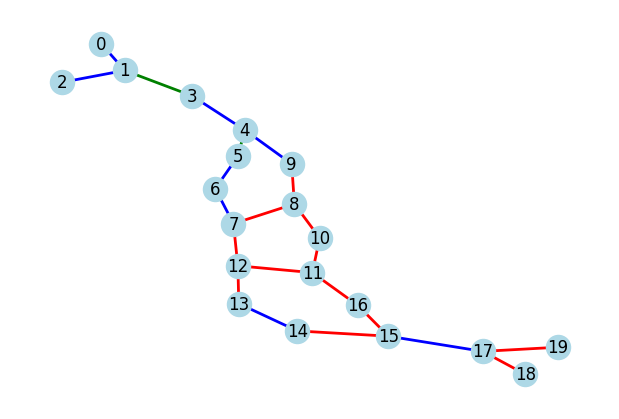

In [46]:
data = dataset[7]
G = to_networkx(data, edge_attrs=['edge_attr'], to_undirected=True)

edge_attrs = data.edge_attr.argmax(dim=1).tolist() 

# Loai lien kết: 0: aromatic, 1: single, 2: double, 3: triple
edge_color_list = ['red', 'blue', 'green', 'grey']  
edge_colors = [edge_color_list[attr] for attr in edge_attrs]
print(edge_colors)

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42) 
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors, width=2)

plt.show()

In [ ]:
import pandas as pd
import torch


@torch.no_grad()
def get_graph_features_df(device, loader):
    atom_types = ["C", "N", "O", "F", "I", "Cl", "Br"]
    all_graphs = []  
    labels = []

    for data in loader:
        data = data.to(device)

        num_graphs = data.batch_size
        for i in range(num_graphs):
            mask = (data.batch == i)  

            node_labels = [atom_types[x.argmax().item()] for x in data.x[mask]]

            all_graphs.append(node_labels)
            labels.append(data.y[i].item())

    max_nodes = max(len(graph) for graph in all_graphs)
    padded_graphs = [graph + ["None"] * (max_nodes - len(graph)) for graph in all_graphs]

    columns = [f'node_{i}' for i in range(max_nodes)]

    df = pd.DataFrame(padded_graphs, columns=columns)
    df['y'] = labels

    return df
df = get_graph_features_df(device, test_loader)
print(df.head())


  node_0 node_1 node_2 node_3 node_4 node_5 node_6 node_7 node_8 node_9  ...  \
0      C      C      C      C      C      C      C      C      C      C  ...   
1      C      C      C      C      C      C      C      C      C      C  ...   
2      C      C      C      C      C      C      C      C      C      C  ...   
3      C      C      O      O      C      C      C      C      C      C  ...   
4      C      C      O      C      C      C      C      C      C      N  ...   

  node_16 node_17 node_18 node_19 node_20 node_21 node_22 node_23 node_24  y  
0       N       O       O       N       O       O       N       O       O  1  
1       N       O       O       N       O       O    None    None    None  1  
2       N       O       O    None    None    None    None    None    None  1  
3       C       N       O       O    None    None    None    None    None  1  
4    None    None    None    None    None    None    None    None    None  0  

[5 rows x 26 columns]
